# ⚛️ VQE Ground State Simulation of H₂  
## Noisy Quantum Simulation & Classical Optimizer Comparison

This notebook explores the **Variational Quantum Eigensolver (VQE)** applied to the hydrogen
molecule **H₂**, executed on a **noisy quantum simulator**.

We compare several classical optimizers under identical noise:

- **GradientDescent**
- **Adam**
- **Momentum**

We study:

- Ground-state convergence under noise  
- Selection of the **worst-performing** optimizer  
- Reconstruction of the **noisy density matrix**  
- Ket-form representation  
- Basis-state population plot  

### 🧪 Noise Model

We use moderate noise typical of NISQ devices:

- **Depolarizing noise:** 2% per qubit  
- **Amplitude damping:** 4% per qubit  

Your package modules (`vqe.core`, `vqe_qpe_common.plotting`) automatically handle:

- caching  
- noise injection  
- device creation  
- unified plotting  
- reproducibility  

---


In [7]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from vqe.core import run_vqe_optimizer_comparison, run_vqe
from vqe_qpe_common.plotting import IMG_DIR

# Molecule setup
symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.7414]
])
basis = "sto-3g"

# Noise parameters
depolarizing_prob = 0.1
amplitude_damping_prob = 0.1

seed = 0


## 🔧 Noisy Optimizer Comparison

We compare how different classical optimizers behave under identical noise.
The call below:

```python
run_vqe_optimizer_comparison(...)
```

automatically:
- handles caching
-runs each optimizer
- produces a convergence plot
- displays it (because plotting functions now use plt.show())
- saves a PNG to images/


⚙️ Running optimizer: GradientDescent
Step 01/75: E = 0.519367 Ha
Step 02/75: E = 0.519337 Ha
Step 03/75: E = 0.519300 Ha
Step 04/75: E = 0.519257 Ha
Step 05/75: E = 0.519206 Ha
Step 06/75: E = 0.519145 Ha
Step 07/75: E = 0.519073 Ha
Step 08/75: E = 0.518988 Ha
Step 09/75: E = 0.518887 Ha
Step 10/75: E = 0.518767 Ha
Step 11/75: E = 0.518624 Ha
Step 12/75: E = 0.518455 Ha
Step 13/75: E = 0.518255 Ha
Step 14/75: E = 0.518017 Ha
Step 15/75: E = 0.517735 Ha
Step 16/75: E = 0.517401 Ha
Step 17/75: E = 0.517005 Ha
Step 18/75: E = 0.516535 Ha
Step 19/75: E = 0.515979 Ha
Step 20/75: E = 0.515319 Ha
Step 21/75: E = 0.514538 Ha
Step 22/75: E = 0.513612 Ha
Step 23/75: E = 0.512516 Ha
Step 24/75: E = 0.511219 Ha
Step 25/75: E = 0.509683 Ha
Step 26/75: E = 0.507867 Ha
Step 27/75: E = 0.505720 Ha
Step 28/75: E = 0.503183 Ha
Step 29/75: E = 0.500189 Ha
Step 30/75: E = 0.496657 Ha
Step 31/75: E = 0.492496 Ha
Step 32/75: E = 0.487599 Ha
Step 33/75: E = 0.481845 Ha
Step 34/75: E = 0.475095 Ha
Step 35/7

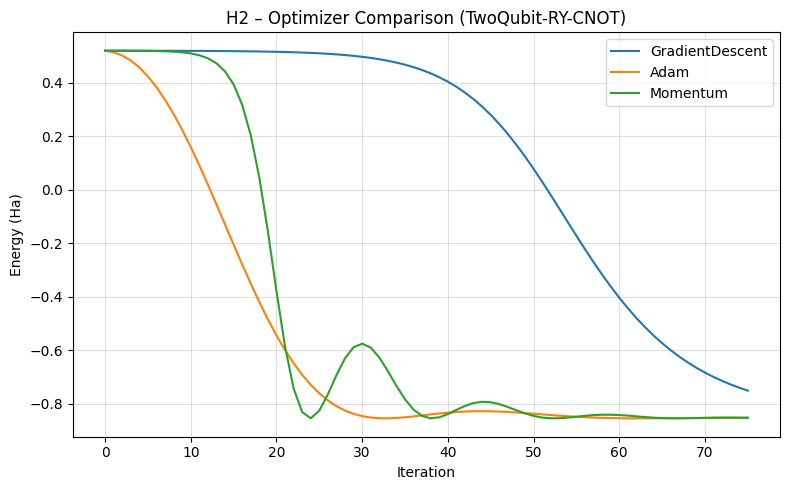

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/H2_optimizer_comparison_ansTwoQubit-RY-CNOT.png


{'energies': {'GradientDescent': [0.5193932132173197,
   0.5193673690829155,
   0.5193367117052435,
   0.519300344989668,
   0.5192572061519682,
   0.5192060347532973,
   0.5191453360414388,
   0.5190733375068679,
   0.5189879373787164,
   0.5188866436934346,
   0.5187665021993211,
   0.5186240110165714,
   0.5184550196467284,
   0.5182546097836713,
   0.5180169544012325,
   0.5177351515761475,
   0.5174010285718417,
   0.517004911052536,
   0.516535351898669,
   0.5159788129548443,
   0.515319292057149,
   0.5145378875501192,
   0.5136122908303985,
   0.512516197380557,
   0.5112186264627857,
   0.5096831391729296,
   0.5078669455200913,
   0.505719893792442,
   0.5031833377298978,
   0.5001888837704496,
   0.4966570288342159,
   0.49249571269657255,
   0.4875988264222117,
   0.4818447445742047,
   0.47509498136600165,
   0.4671931134708988,
   0.45796416465219225,
   0.4472147068755003,
   0.43473399463088813,
   0.42029651255788786,
   0.4036663542881518,
   0.38460385549944853,
   

In [8]:
optimizers = ["GradientDescent", "Adam", "Momentum"]

comparison = run_vqe_optimizer_comparison(
    molecule="H2",
    ansatz_name="TwoQubit-RY-CNOT",
    optimizers=optimizers,
    steps=75,
    stepsize=0.1,
    noisy=True,
    depolarizing_prob=depolarizing_prob,
    amplitude_damping_prob=amplitude_damping_prob,
    force=False,
    show=True
)

comparison


## ⭐ Identify the Worst-Performing Optimizer

Since `run_vqe_optimizer_comparison()` does not return the energy traces
(it only plots them), we now compute the final energies for each optimizer.

We select the **worst optimizer**, i.e. the one with the **highest final energy**:


In [9]:
worst_optimizer = max(comparison["final_energies"], key=comparison["final_energies"].get)
print(f"🏆 Worst optimizer: {worst_optimizer}")


🏆 Worst optimizer: GradientDescent


## 🔍 Full VQE Run Using the Worst Optimizer

We now run a complete noisy VQE with:

- **ansatz:** TwoQubit-RY-CNOT  
- **optimizer:** worst-performing optimizer  
- **noise:** 2% depolarizing + 4% amplitude damping  
- **75 optimization steps**  

This returns:

- final energy  
- full density matrix (real + imaginary parts)  
- convergence trace  
- metadata  


In [10]:
res = run_vqe(
    molecule="H2",
    ansatz_name="TwoQubit-RY-CNOT",
    optimizer_name=worst_optimizer,
    n_steps=75,
    stepsize=0.1,
    noisy=True,
    depolarizing_prob=depolarizing_prob,
    amplitude_damping_prob=amplitude_damping_prob,
    plot=False,
    seed=0,
    force=False
)

rho = np.array(res["final_state_real"]) + 1j * np.array(res["final_state_imag"])
diag_elements = np.diag(rho)
diag_elements



📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__TwoQubit-RY-CNOT__GradientDescent__VQE__noisy__s0__b997d6e2d647.json


tensor([5.10152463e-02+0.j, 3.25629232e-03+0.j, 3.25629232e-03+0.j,
        2.07848446e-04+0.j, 1.61298370e-01+0.j, 1.02956406e-02+0.j,
        1.02956406e-02+0.j, 6.57168551e-04+0.j, 1.61298370e-01+0.j,
        1.02956406e-02+0.j, 1.02956406e-02+0.j, 6.57168551e-04+0.j,
        5.09988014e-01+0.j, 3.25524264e-02+0.j, 3.25524264e-02+0.j,
        2.07781445e-03+0.j], requires_grad=True)

## 🧮 Ket Representation of Noisy Density Matrix

For mixed states, the diagonal entries of the density matrix represent
**population** in each computational basis state.

We extract significant populations and express them in a compact ket expansion:


In [11]:
threshold = 1e-2
num_wires = int(np.log2(len(diag_elements)))

ket_terms = []
for idx, amp in enumerate(diag_elements):
    if abs(amp) > threshold:
        ket_terms.append(f"({amp:.4f}|{idx:0{num_wires}b}⟩)")

ket_notation = " + ".join(ket_terms)

print("Noisy VQE approximate state:")
print(f"|ψ⟩ = {ket_notation}")


Noisy VQE approximate state:
|ψ⟩ = (0.0510+0.0000j|0000⟩) + (0.1613+0.0000j|0100⟩) + (0.0103+0.0000j|0101⟩) + (0.0103+0.0000j|0110⟩) + (0.1613+0.0000j|1000⟩) + (0.0103+0.0000j|1001⟩) + (0.0103+0.0000j|1010⟩) + (0.5100+0.0000j|1100⟩) + (0.0326+0.0000j|1101⟩) + (0.0326+0.0000j|1110⟩)


## 📊 Basis-State Population Plot (Diagonal of ρ)

Below, we visualise the diagonal entries of the density matrix:

- **Real** component (population)
- **Imaginary** component (stacked)

This provides a clear view of which computational basis states survive under noise.


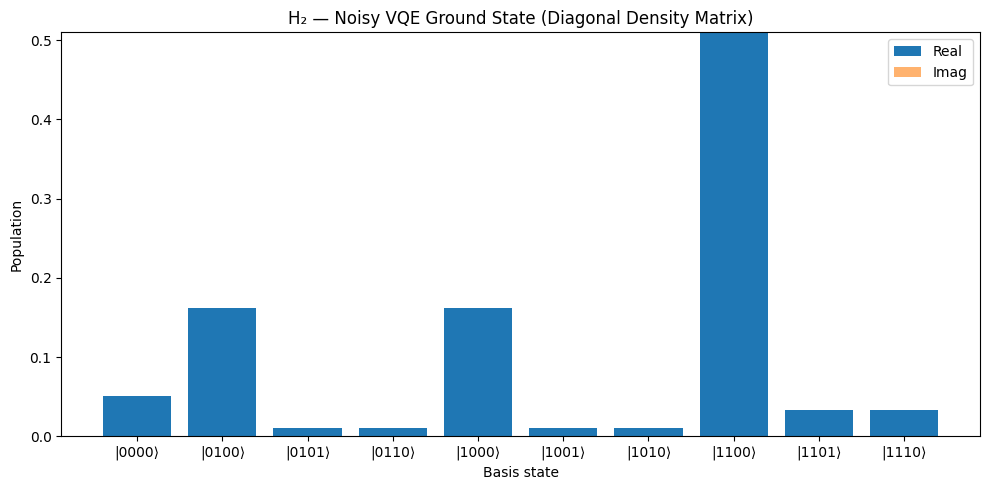

In [12]:
indices = np.where(abs(diag_elements) > threshold)[0]
values = diag_elements[indices]
labels = [f"|{i:0{num_wires}b}⟩" for i in indices]

plt.figure(figsize=(10, 5))
plt.bar(labels, values.real, label="Real")
plt.bar(labels, values.imag, bottom=values.real, alpha=0.6, label="Imag")

plt.xlabel("Basis state")
plt.ylabel("Population")
plt.title("H₂ — Noisy VQE Ground State (Diagonal Density Matrix)")
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(IMG_DIR, "H2_Noisy_Ground_State.png"), dpi=300)
plt.show()
